**Purpose:** using a Genetic Algorithm (GA) to find optimal configuration settings for closed spaces using indoor spatioal Cell-DEVS models.

**Project:** CO2 dispersion

This file uses:
- the ScenariosGenerator class to generate different scenarios for CO2 models.
- Pypi geneticalgorithm library.
- Cadmium simulator.

**To run this code:**
- install Cadmium (https://github.com/SimulationEverywhere-Models/Cell-DEVS-CO2_spread_indoor/blob/master/User%20Manual.txt)
- clone https://github.com/staubibr/arslab-converter to be in the same directory as the scripts under Cell-DEVS_GA
- compile computer_lab_infection Cell-DEVS model using the cmake and make as explained in the manual
- export ga.ipuynb and generator.ipynb as executable scripts
- from Ubuntu shell of the same directory: (1) make sure there is a results dirctory and (2) run the generated script "python3 ga.py"
- the output of the GA will be in GA_ouput.json: e.g., [9.0, 8.0, 7.0, 7.0] is the list of values for an objective function for 4 iterations of the GA

In [21]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga
from generator import ScenariosGenerator

#for running Cadmium
import os
import subprocess

#for using ArsLab parser to read the log file
import sys
sys.path.append('./arslab-converter')
from parsers.cadmium.structure import CadmiumStructure
from parsers.cadmium.state import CadmiumState
from formats.format import Format

#for storing GA results and others
import json


In [3]:
# Function: get_exposed_occupants
# Purpose: extracts the required data from the log files (That is the the number of occupants who are at higher risk by the end of simulation)
# Arguments: log_File: the log file Carmium produce as a result of the simulation ("state.txt")
# Return:
    #occupants_at_risk: the number of occupants who are of type EXPOSED_CO2_SOURCE = -250
        
def get_exposed_occupants(log_file):

    EXPOSED_CO2_SOURCE = -250   #The function could be modified to be more general. 
                                #In this case this valud could be read from config or added as an argument.
    
    log_file = "results/" + log_file
    
    #in the case of an invalid log_file return -1 
    if (not os.path.isfile(log_file)) or (log_file.find("state") == -1):
        return -1
    
    frame_index = 0
    parsing_files = ["structure.json", log_file]
    structure = CadmiumStructure().parse(parsing_files)
    messages = CadmiumState(structure).parse(parsing_files)

    #Get the number of different time frames we have
    number_of_frames = messages.size()
    occupants_at_risk = 0
    
    #get the last time frame to know the numbe rof sick occupants at the end of simulation
    frame = messages.get_frame(str(number_of_frames-1))
    
    #loop on the timeframes in each file
    occupants_at_risk = 0
    #loop on all the messages at each timeframe 
    for message in frame:
        if( int(message.values[2]) == EXPOSED_CO2_SOURCE ):
            occupants_at_risk = occupants_at_risk + 1
        
    return occupants_at_risk

In [9]:
# Function: evlauate_vent_loc
# Purpose: (1) uses ScearioGenerator class to generate a JSON CO2 scenario using the list of vent_loc argument, 
            #(2) calls cadmium to run the simulator,
            #(3) calls get_exposed_occupants to find the number of occupants who are at risk by the end of simulation.
# Arguments: vent_loc: an numpy array of values sent by the calling GA. For example, vent_loc[0] and vent_loc[1] are the xy coordinates of the first vent.
# Return:
    #occupants_at_risk: the number of occupants who are of type EXPOSED_CO2_SOURCE = -250
    
#a global dictionary where the number of exposed occupants for all simulated scenarios is stored. 
#The purpose of this is to avoid running the simulation again for a json scenario with vent_loc that has been used again.

vent_results_database = dict()

def evlauate_vent_loc(vent_loc):
    global vent_results_database
    
    #if the scenario with this vent location has been simulated before
    #do not simulate again
    #return the number of exposed occupants stored from previous simulation
    if str(vent_loc) in vent_results_database:
        return vent_results_database[str(vent_loc)]
    
    output_file = "state.txt"
    #generate a scenario with this vent location
    #the ScenariosGenerator reads configurations such as initial scenario name, vet size, vent concentration, etc from a configuration file
    generator = ScenariosGenerator("in/config.json")
    scenario_name = generator.create_vent_scenario(vent_loc)

    #run the simulation
    #this could also be read froma config file in future versions
    model_path = "../../computer_lab_infection/bin/co2_lab"
    ensure
    scenarios_path = "out/" + scenario_name

    if os.path.isfile(scenarios_path):
        #create results directory #the simulator expects a directory named "results" to be available.
        #call simulator
        subprocess.check_call([model_path, scenarios_path])
        
        #read the log to get the number of occupants exposed to high CO2 for a long time
        #and therefore are at risk of getting infected!
        exposed_occupants = get_exposed_occupants(output_file)

    #print("number of sick occuapnst:" + str(exposed_occupants) +",scenrio name: " + scenario_name)

    vent_results_database[str(vent_loc)] = exposed_occupants    

    return exposed_occupants

In [10]:
# Function: ga_vents
# Purpose: Runs the Genetic Algorithm to find best ventilation lcoations.
    #this function is built for a specific scenario. We can make it more general by reading the variables boundaries from a config file.

def ga_vents():
    #We have three variables: x coord, y coord, and output
    varbound=np.array([[4,19],[4,31],[4,19],[4,31],[4,19],[4,31],[4,19],[4,31]])
    vartype=np.array([['int'],['int'],['int'],['int'],['int'],['int'],['int'],['int']])

    algorithm_param = {'max_num_iteration': 5,'population_size':3,'mutation_probability':0.1,'elit_ratio': 0.01,'crossover_probability': 0.9, 
                       'parents_portion': 0.5,'crossover_type':'uniform','max_iteration_without_improv':15}

    model = ga(function=evlauate_vent_loc,dimension=8,variable_type_mixed=vartype,variable_boundaries=varbound, 
               algorithm_parameters=algorithm_param, function_timeout=3600.0)

    model.run()
    
    convergence= model.report
    solution= model.output_dict

    print(convergence)
    print(solution)

    json.dump( convergence, open( "GA_Output.json", 'a'))


In [11]:
# Function: evlauate_seating
# Purpose: (1) uses ScearioGenerator class to generate a JSON CO2 scenario using the list of suggested occupants locations occupants_loc argument, 
            #(2) calls cadmium to run the simulator,
            #(3) calls get_exposed_occupants to find the number of occupants who are at risk by the end of simulation.
# Arguments: occupants_loc: an numpy array of values sent by the calling GA. For example, occupants_loc[0] and occupants_loc[1] are the xy coordinates of
            #the first occupant.
# Return:
    #occupants_at_risk: the number of occupants who are of type EXPOSED_CO2_SOURCE = -250
    
#a global dictionary where the number of exposed occupants for all simulated scenarios is stored. 
#The purpose of this is to avoid running the simulation again for a json scenario with occupants_loc that has been used again.

seats_results_database = dict()
counter = 0

def evlauate_seating(occupants_loc):
    global seats_results_database
    global counter
    
    #if the scenario with this vent location has been simulated before
    #do not simulate again
    #return the number of exposed occupants stored from previous simulation
    if str(occupants_loc) in seats_results_database:
        return seats_results_database[str(occupants_loc)]
    
    output_file = "state.txt"
    #generate a scenario with this vent location
    generator = ScenariosGenerator("in/config.json")
    counter = counter +1
    scenario_name = generator.create_seats_scenario(occupants_loc, counter)

    #run the simulation
    model_path = "../../computer_lab_infection/bin/co2_lab"
    scenarios_path = "out/" + scenario_name

    if os.path.isfile(scenarios_path):
        #create results directory #the simulator expects a directory named "results"
        #ensure_dir(self.results_path)
        #call simulator
        subprocess.check_call([model_path, scenarios_path])
        
        #read the log to get the number of occupants exposed to high CO2 for a long time
        #and therefore are at risk of getting infected!
        exposed_occupants = get_exposed_occupants(output_file)
    
    #print("number of sick occuapnst:" + str(exposed_occupants) +",scenrio name: " + scenario_name)
    seats_results_database[str(occupants_loc)] = exposed_occupants    
    
    return exposed_occupants


In [19]:
# Function: ga_seats
# Purpose: Runs the Genetic Algorithm to find best seating arrangement for occupants.
    #this function is built for a specific scenario. We can make it more general by reading the variables boundaries from a config file.

def ga_seats():

    #assuming all occupants are placed 4 cells away from the boundaries of the model. These variable can be read from a config file if needed.
    varbound=np.array([[4,19],[4,31],[4,19],[4,31],[4,19],[4,31],[4,19],[4,31],[4,19],[4,31],[4,19],[4,31],[4,19],[4,31],[4,19],[4,31],
                       [4,19],[4,31],[4,19],[4,31], [4,19],[4,31],[4,19],[4,31],[4,19],[4,31],[4,19],[4,31],[4,19],[4,31],[4,19],[4,31],
                       [4,19],[4,31],[4,19],[4,31],[4,19],[4,31],[4,19],[4,31],[4,19],[4,31],[4,19],[4,31],[4,19],[4,31],[4,19],[4,31],
                       [4,19],[4,31]])
                  
    algorithm_param = {'max_num_iteration': 3,'population_size':5,'mutation_probability':0.1,'elit_ratio': 0.01,'crossover_probability': 0.9,
                       'parents_portion': 0.5,'crossover_type':'uniform','max_iteration_without_improv':10}

    model=ga(function=evlauate_seating,dimension=50,variable_type='int',variable_boundaries=varbound, algorithm_parameters=algorithm_param, 
             function_timeout=3600.0)

    model.run()

    convergence= model.report
    solution= model.output_dict

    print(convergence)
    print(solution)

    json.dump( convergence, open( "GA_Output.json", 'a'))

 The best solution found:                                                                           
 [11. 24. 17. 22. 11. 29. 13.  9. 18. 15.  9. 21. 13.  5.  4.  6. 18.  8.
  9. 13. 14. 16. 18. 31.  4. 17. 16. 21. 17. 18. 16. 28.  4. 12.  6. 26.
 17.  8. 12. 13. 15. 22. 13. 26. 15. 25. 14. 20. 10. 14.]

 Objective function:
 10


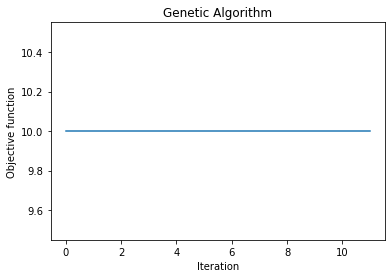


{'variable': array([11., 24., 17., 22., 11., 29., 13.,  9., 18., 15.,  9., 21., 13.,
        5.,  4.,  6., 18.,  8.,  9., 13., 14., 16., 18., 31.,  4., 17.,
       16., 21., 17., 18., 16., 28.,  4., 12.,  6., 26., 17.,  8., 12.,
       13., 15., 22., 13., 26., 15., 25., 14., 20., 10., 14.]), 'function': 10}


In [20]:
print("Case Study I: finding best seating arrangement")
ga_seats()

 The best solution found:                                                                           
 [ 7. 21. 16. 10. 16. 31. 15.  9.]

 Objective function:
 10


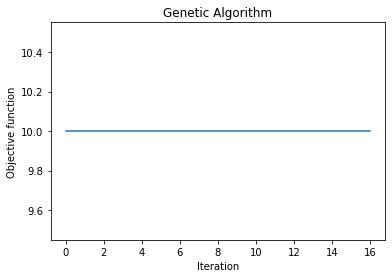


{'variable': array([ 7., 21., 16., 10., 16., 31., 15.,  9.]), 'function': 10}


In [17]:
print("Case Study II: finding best vents locations")
ga_vents()